In [2]:
#!git clone https://github.com/SparklePh/Seagate_Workshop

fatal: destination path 'Seagate_Workshop' already exists and is not an empty directory.


In [3]:
#%cd /content/Seagate_Workshop

/content/Seagate_Workshop


In [4]:
import torch

# Is CUDA available?
print("CUDA available:", torch.cuda.is_available())

# Current device index
print("Current device:", torch.cuda.current_device())

# Name of the GPU
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))

# Number of GPUs
print("Number of GPUs:", torch.cuda.device_count())

# CUDA version PyTorch was built with
print("CUDA version:", torch.version.cuda)

CUDA available: True
Current device: 0
GPU name: Tesla T4
Number of GPUs: 1
CUDA version: 12.8


In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 48.2 MB/s eta 0:00:00


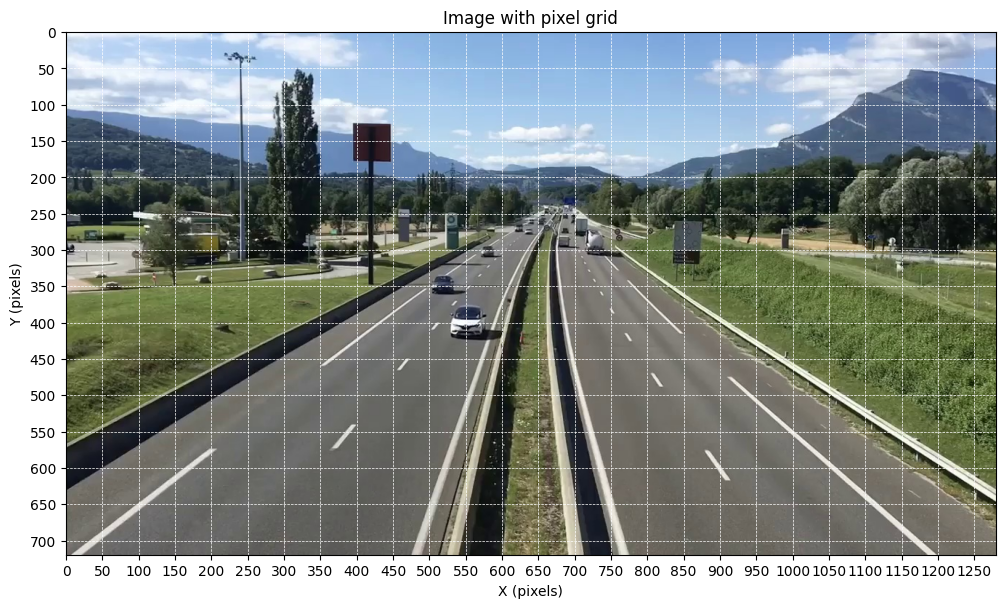

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read the image and convert to RGB
img = Image.open("data/highway_frame.jpg").convert("RGB")
img_array = np.array(img)

# Plot the image
plt.figure(figsize=(12, 8))
plt.imshow(img_array)
plt.axis("on")  # Turn on the axis to show X and Y coordinates

# Set ticks every 50 pixels
plt.xticks(np.arange(0, img_array.shape[1], 50))
plt.yticks(np.arange(0, img_array.shape[0], 50))

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5)  # White dashed grid

# Add axis labels and title
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.title("Image with pixel grid")

# Display the plot
plt.show()

In [7]:
from ultralytics import YOLO

model = YOLO("model/yolov8l_car.pt")
results = model("data/highway_frame.jpg")

# results เป็น list ของ Results objects
r = results[0]

# 1. ดึง bounding boxes
boxes = r.boxes  # .xyxy, .xywh, .cls, .conf

# 2. ดึง coordinates
xyxy = boxes.xyxy.cpu().numpy()      # [x1, y1, x2, y2]
cls  = boxes.cls.cpu().numpy()       # class ids
conf = boxes.conf.cpu().numpy()      # confidence

# 3. ดึง object IDs (ถ้า track)
ids = boxes.id.int().cpu().numpy() if boxes.id is not None else None



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/Seagate_Workshop/data/highway_frame.jpg: 384x640 1 person, 5 cars, 1 truck, 90.4ms
Speed: 9.1ms preprocess, 90.4ms inference, 40.7ms postprocess per image at shape (1, 3, 384, 640)


# Load pretrained YOLO model

In [8]:
from ultralytics import YOLO

# Load YOLOv8 pretrained model
model = YOLO("model/yolov8l_car.pt")  # small model for fast inference
model.info()

YOLOv8l summary: 209 layers, 43,691,520 parameters, 0 gradients, 165.7 GFLOPs


(209, 43691520, 0, 165.742848)

# Prepare video and image sample

In [9]:
# Using uploaded video
video_path = "/content/Seagate_Workshop/data/highway.mp4"


# Run YOLO detection on one frame (exploration)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 2 packages in 103ms
Prepared 1 package in 25ms
Installed 1 package in 2ms
 + lap==0.5.12

requirements: AutoUpdate success ✅ 0.5s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect



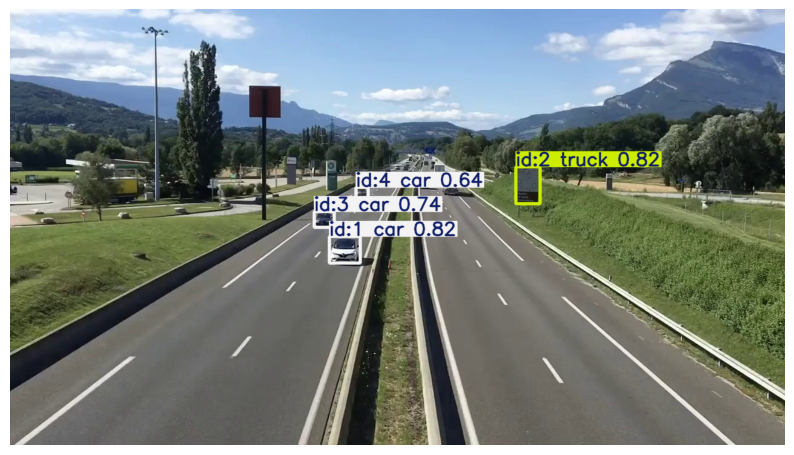

In [10]:
import cv2
import matplotlib.pyplot as plt


# Read image with OpenCV
image_path = "data/highway_frame.jpg"

# Read one frame
img = cv2.imread(image_path)

# Run YOLO detection (track=False for single frame)
results = model.track(img, conf=0.5, persist=True, verbose=False)

# Display the frame with boxes
plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# Extract object centers

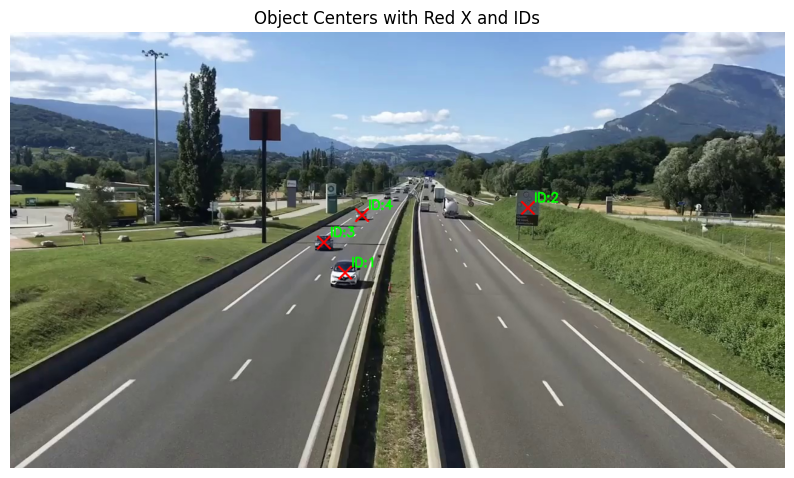

In [11]:
#เพิ่มเติมจากตอนสอนทำให้นับตัวรถได้ดีขึ้น เนื่องจากเพิ่ม track_ids มาทำให้นับ ID รถถูกแต่ของเก่านับไม่ถูก
def get_object_centers(results):
    centers = []
    ids = []
    if results[0].boxes.id is None:  # ถ้าไม่มีการ track ID
        return centers, ids

    boxes = results[0].boxes.xyxy.cpu().numpy()   # (x1,y1,x2,y2)
    track_ids = results[0].boxes.id.cpu().numpy().astype(int)  # ดึง object IDs

    for box, obj_id in zip(boxes, track_ids):
        x1, y1, x2, y2 = box
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
        centers.append((cx, cy))
        ids.append(obj_id)

    return centers, ids

centers, ids = get_object_centers(results)

img_marked = img.copy()
for (cx, cy), oid in zip(centers, ids):
    cv2.drawMarker(img_marked, (cx, cy), (0,0,255),
                   markerType=cv2.MARKER_TILTED_CROSS,
                   markerSize=20, thickness=2, line_type=cv2.LINE_AA)
    cv2.putText(img_marked, f"ID:{oid}", (cx+10, cy-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

plt.figure(figsize=(10,8))
plt.imshow(cv2.cvtColor(img_marked, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Object Centers with Red X and IDs")
plt.show()


# Count vehicles crossing ROI line (video)

In [12]:
# ROI line (only a segment)
line_y = 500
line_y_band = 10 # เพิ่มเติมจากการสอนปรับค่านี้จะทำให้นับรถได้ดีขี้น เนื่องจากเส้นแกน y เก่ามีโอกาศที่รถจะไม่เจอเนื้องจากบ้างไป
line_x_start = 200  # กำหนดจุดเริ่มเส้น
line_x_end = 500   # กำหนดจุดสิ้นสุดเส้น

counted_ids = set()
total_count = 0

# Open video writer
cap = cv2.VideoCapture(video_path)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("highway_counted.avi", fourcc, fps, (width, height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    results = model.track(frame, conf=0.5, persist=True, verbose=False)
    centers, ids = get_object_centers(results)

    # Count objects crossing ROI segment
    for (cx, cy), obj_id in zip(centers, ids):
        if line_y - line_y_band < cy < line_y + line_y_band and line_x_start <= cx <= line_x_end and obj_id not in counted_ids:
            counted_ids.add(obj_id)
            total_count += 1

    # Draw ROI segment and centers
    # ROI segment line
    cv2.line(frame, (line_x_start, line_y),
         (line_x_end, line_y), (0, 255, 255), 2)

    # Object centers
    for cx, cy in centers:
        cv2.circle(frame, (cx, cy), 4, (0, 0, 255), -1)

    # Count text
    cv2.putText(frame, f"Count: {total_count}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    out.write(frame)

cap.release()
out.release()
print(f"Video saved to highway_counted.mp4")

Video saved to highway_counted.mp4


# Display counted video in Colab

In [13]:
INPUT_VIDEO =  "/content/Seagate_Workshop/highway_counted.avi"
OUT_VIDEO = "/content/Seagate_Workshop/highway_counted.mp4"

!ffmpeg -i  {INPUT_VIDEO} -vcodec libx264 {OUT_VIDEO}


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [14]:
from IPython.display import HTML, display
from base64 import b64encode

mp4 = open("highway_counted.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

display(HTML(f"""
<video width="800" height="480" controls>
    <source src="{data_url}" type="video/mp4">
</video>
"""))


Output hidden; open in https://colab.research.google.com to view.